# Instancia de librarias

In [1]:
import pandas as pd
import numpy as np
# import datetime as dt
from datetime import datetime

# Series de tiempo
import scipy.stats as stats
import statistics
from statsmodels.tsa.seasonal import seasonal_decompose # graficas de estacionalidad y tendencia
from statsmodels.tsa.stattools import adfuller # prueba 
from statsmodels.tsa.statespace.sarimax import SARIMAX #SARIMAX
import pmdarima as pm # autoarima

from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler  # Estandarización de los datos
from sklearn.model_selection import cross_val_score

# import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

# Formato de visualización por centenas
pd.options.display.float_format = '{:,.2f}'.format

# Graficas
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;sns.set_theme(color_codes=True)

# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

print("Setup complete")

Setup complete


In [2]:
# !pip install prophet --user


# Importación de datos

In [3]:
path = r'E:\\skillsForIndustry/project_wallmart/data/Walmart_Store_sales.csv'
wall_data = pd.read_csv(path, header=0, encoding='utf-8')

In [4]:
wall_data['Date'] = pd.to_datetime(wall_data['Date'],format="%d-%m-%Y",dayfirst=True)
# wall_data.info()
wall_data['year'] = pd.DatetimeIndex(wall_data['Date']).year
wall_data['month'] = pd.DatetimeIndex(wall_data['Date']).month
wall_data['day'] = pd.DatetimeIndex(wall_data['Date']).day
wall_data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day
0,1,2010-02-05,"1,643,690.90",0,42.31,2.57,211.10,8.11,2010,2,5
1,1,2010-02-12,"1,641,957.44",1,38.51,2.55,211.24,8.11,2010,2,12
2,1,2010-02-19,"1,611,968.17",0,39.93,2.51,211.29,8.11,2010,2,19
3,1,2010-02-26,"1,409,727.59",0,46.63,2.56,211.32,8.11,2010,2,26
4,1,2010-03-05,"1,554,806.68",0,46.50,2.62,211.35,8.11,2010,3,5


#### Performance

In [5]:
def performance(a,b):
    print('Mean Absolute Error: ',metrics.mean_absolute_error(a,b))
    print('Mean Square Error: ',metrics.mean_squared_error(a,b))
    print('Root Mean Square Error: ',np.sqrt(metrics.mean_squared_error(a,b)))
    print('Mean Absolute Percentage Error: ', metrics.mean_absolute_percentage_error(a,b))
    
    plt.figure(figsize=(10,8),dpi=60)
    sns.regplot(b,a);
    
def cross_validation(model,a,b):
    cv = cross_val_score(model,a,b,cv=10,scoring='r2')
    print(f'Cross validation: {cv.mean()*100}%')

#### ADF

In [6]:
def adf(series,column_name):
    print(f'Resultados ADF: ,{column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used', 'Observation number'])
    for key, value in dftest[4].items():
        dfoutput['Critical Values (%s)'%key] = value
    print(dfoutput)
    if ((dftest[1] > 0.00) & (dftest[1] <= 0.05)):
        print('Los datos son estacionarios')
    else:
        print('Los datos no son estacionarios')

## Series de Tiempo

## NeuralProphet

In [19]:
# !pip install neuralprophet --user
from neuralprophet import NeuralProphet
import pickle

In [20]:
store_20 = wall_data[wall_data['Store']==20].iloc[:,[1,2,8,9,10]]
# store_20['Date'] = pd.PeriodIndex(store_20.Date,freq='M')
# store_20 = store_20.groupby(['Date'])[['Weekly_Sales','Date']].mean().reset_index()
# store_20 = store_20.rename(columns={'Date':'ds','Weekly_Sales':'y'})
# store_20['ds'] = store_20.ds.astype(str)
# store_20['ds'] = pd.to_datetime(store_20['ds'])
# store_20.info()
store_20 = store_20.iloc[:,[0,1]]
store_20 = store_20.rename(columns={'Date':'ds','Weekly_Sales':'y'})
store_20.info()
store_20.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 2717 to 2859
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      143 non-null    datetime64[ns]
 1   y       143 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


,ds,y
2717,2010-02-05,"2,401,395.47"
2718,2010-02-12,"2,109,107.90"
2719,2010-02-19,"2,161,549.76"
2720,2010-02-26,"1,898,193.95"
2721,2010-03-05,"2,119,213.72"


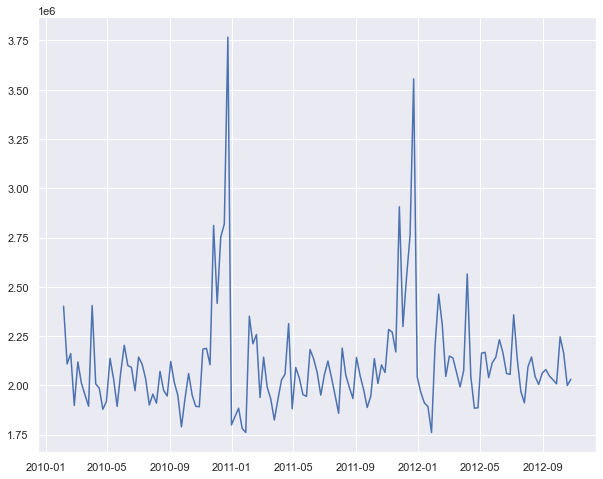

In [21]:
plt.plot(store_20['ds'],store_20.y);

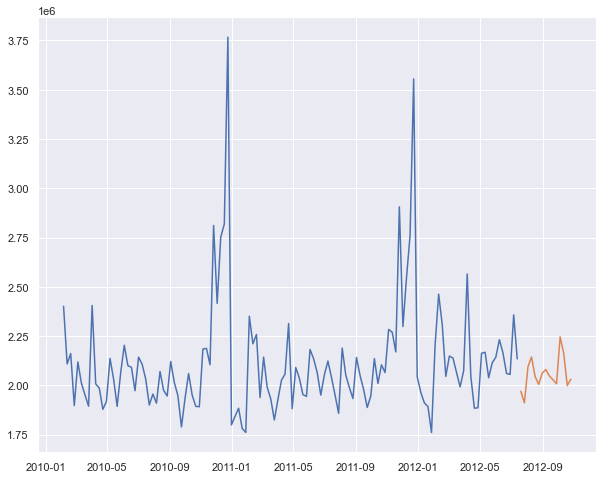

In [39]:
train = store_20[:len(store_20)-15]  # primero datos
test = store_20[len(store_20)-15:]   # últimos datos
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(train.ds,train.y)
plt.plot(test.ds,test.y)

In [40]:
m = NeuralProphet()
m.fit(train, freq='D')

INFO - (NP.df_utils._infer_frequency) - Major frequency W-FRI corresponds to 99.219% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency W-FRI
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 464


  0%|          | 0/108 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.56E-02, min: 9.37E-02


  0%|          | 0/108 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.32E-02, min: 1.38E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.36E-02
Epoch[464/464]: 100%|█| 464/464 [00:09<00:00, 51.26it/s, SmoothL1Loss=0.024, MAE=1.3e+5, RMSE=1.8e+5, Loss=0.0183, RegL


,SmoothL1Loss,MAE,RMSE,Loss,RegLoss
0,0.18,"393,237.18","536,227.09",0.14,0.00
1,0.17,"388,154.88","545,215.59",0.13,0.00
2,0.17,"382,841.06","544,554.45",0.13,0.00
3,0.16,"377,435.51","532,480.24",0.13,0.00
4,0.16,"371,615.99","520,709.68",0.12,0.00
...,...,...,...,...,...
459,0.02,"129,972.26","186,203.51",0.02,0.00
460,0.02,"129,969.73","192,442.69",0.02,0.00
461,0.02,"129,968.18","189,543.32",0.02,0.00
462,0.02,"129,968.09","191,706.93",0.02,0.00


In [41]:
future = m.make_future_dataframe(train,periods=800)
np = m.predict(future)
np.head()

INFO - (NP.df_utils._infer_frequency) - Major frequency W-FRI corresponds to 99.219% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency W-FRI
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.875% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.875% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,residual1,yhat1,trend,season_yearly
0,2012-07-14,None,NaN,"2,095,284.75","2,229,179.00","-133,894.09"
1,2012-07-15,None,NaN,"2,094,747.00","2,229,602.75","-134,855.69"
2,2012-07-16,None,NaN,"2,094,986.50","2,230,026.50","-135,039.95"
3,2012-07-17,None,NaN,"2,095,997.12","2,230,450.25","-134,453.09"
4,2012-07-18,None,NaN,"2,097,763.50","2,230,874.00","-133,110.41"


In [42]:
np.tail()

,ds,y,residual1,yhat1,trend,season_yearly
795,2014-09-17,None,NaN,"2,415,657.50","2,566,073.00","-150,415.36"
796,2014-09-18,None,NaN,"2,419,950.50","2,566,496.75","-146,546.28"
797,2014-09-19,None,NaN,"2,424,800.75","2,566,920.50","-142,119.70"
798,2014-09-20,None,NaN,"2,430,150.50","2,567,344.25","-137,193.69"
799,2014-09-21,None,NaN,"2,435,936.00","2,567,768.00","-131,832.00"


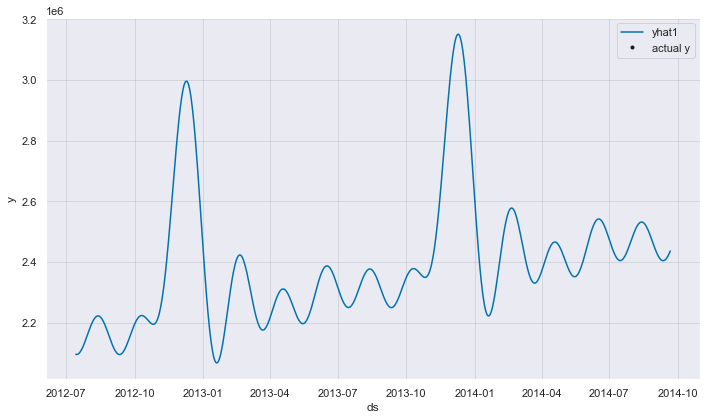

In [43]:
plt.rcParams["figure.figsize"] = (10,8)
m.plot(np);

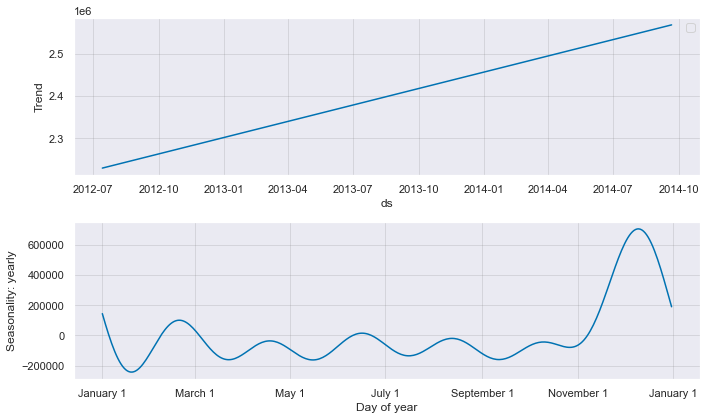

In [44]:
m.plot_components(np);

In [45]:
with open ('forecast_model.pkl','wb') as f:
    pickle.dump(m,f)

In [46]:
with open ('forecast_model.pkl','rb') as f:
    m = pickle.load(f)

In [47]:
m

In [48]:
future = m.make_future_dataframe(train,periods=1600)
np = m.predict(future)
np.head()

INFO - (NP.df_utils._infer_frequency) - Major frequency W-FRI corresponds to 99.219% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency W-FRI
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.938% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.938% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,residual1,yhat1,trend,season_yearly
0,2012-07-14,None,NaN,"2,095,284.75","2,229,179.00","-133,894.09"
1,2012-07-15,None,NaN,"2,094,747.00","2,229,602.75","-134,855.69"
2,2012-07-16,None,NaN,"2,094,986.50","2,230,026.50","-135,039.95"
3,2012-07-17,None,NaN,"2,095,997.12","2,230,450.25","-134,453.09"
4,2012-07-18,None,NaN,"2,097,763.50","2,230,874.00","-133,110.41"


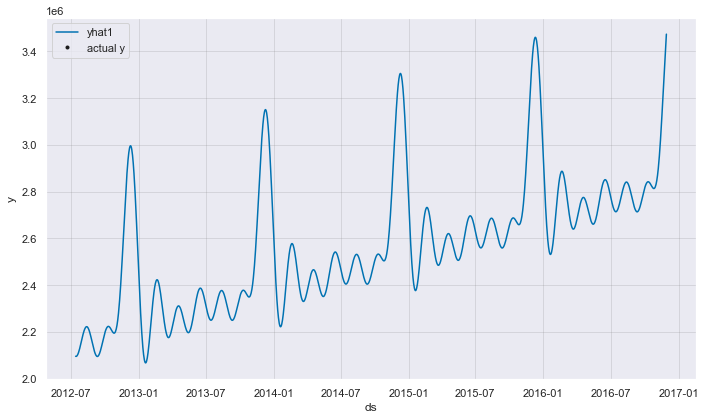

In [49]:
plt.rcParams['figure.figsize']=(10,8)
m.plot(np);